# Cosine Regression on the Sphere with Polynomial SGD
This notebook evaluates SGD performance on data generated from the spherical cosine model:
$$
y = \cos(\langle x, u \rangle) + \varepsilon
$$
where $ x \in \mathbb{R}^d $. We examine the generalization and convergence behavior of fixed, halving, and diminishing stepsize strategies when fitting polynomial models to this data.

In [ ]:
import sys
sys.path.append("..") 

import numpy as np
import matplotlib.pyplot as plt
from src.sgd.sgd import SGD
from src.data.generate_synthetic_data import generate_cosine_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from mpl_toolkits.mplot3d import Axes3D

### Summary of Train/Test Error Over 20 Runs

We generate report the mean ± std of final losses for polynomial degrees 1-4, observing how input dimension aligns interacts with polynomial degree for approximating the cosine function on the sphere. 

In [ ]:

n_runs = 20
degrees = [1, 2, 3, 4]
dimension = 3
noise = 0.01

results_summary = {}

for degree in degrees:
    train_losses = {"fixed": [], "halving": [], "diminishing": []}
    test_losses = {"fixed": [], "halving": [], "diminishing": []}

    for run in range(n_runs):
        X, y, _ = generate_cosine_data(m=100, d=dimension, noise=noise)
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3)

        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train_raw)
        X_test_poly = poly.transform(X_test_raw)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_poly)
        X_test = scaler.transform(X_test_poly)

        for method in ["fixed", "halving", "diminishing"]:
            sgd = SGD(X_train, y_train, num_iterations=5000, noise=noise)
            w, obj, grad, dist = sgd.optimize(stepsize_type=method)
            train_losses[method].append(obj[-1])

            test_pred = X_test @ w[1:] + w[0]
            test_loss = np.mean((test_pred - y_test) ** 2)
            test_losses[method].append(test_loss)

    results_summary[degree] = {"train": train_losses, "test": test_losses}

# --- Print Summary
print(f"\n====== Polynomial Regression on Cosine Data) ======")
for degree in degrees:
    print(f"\nDegree {degree}:")
    for method in ["fixed", "halving", "diminishing"]:
        tr = results_summary[degree]["train"][method]
        te = results_summary[degree]["test"][method]
        print(f"{method.capitalize()} Results:")
        print(f"  Train Loss  - Mean: {np.mean(tr):.4f}, Std: {np.std(tr):.4f}")
        print(f"  Test Loss   - Mean: {np.mean(te):.4f}, Std: {np.std(te):.4f}")


====== Polynomial Regression on Cosine Data) ======

Degree 1:
Fixed Results:
  Train Loss  - Mean: 0.0170, Std: 0.0052
  Test Loss   - Mean: 0.0363, Std: 0.0087
Halving Results:
  Train Loss  - Mean: 0.0116, Std: 0.0034
  Test Loss   - Mean: 0.0275, Std: 0.0080
Diminishing Results:
  Train Loss  - Mean: 0.0090, Std: 0.0015
  Test Loss   - Mean: 0.0213, Std: 0.0046

Degree 2:
Fixed Results:
  Train Loss  - Mean: 0.0001, Std: 0.0000
  Test Loss   - Mean: 0.0002, Std: 0.0001
Halving Results:
  Train Loss  - Mean: 0.0000, Std: 0.0000
  Test Loss   - Mean: 0.0001, Std: 0.0000
Diminishing Results:
  Train Loss  - Mean: 0.0001, Std: 0.0000
  Test Loss   - Mean: 0.0002, Std: 0.0001

Degree 3:
Fixed Results:
  Train Loss  - Mean: 0.0001, Std: 0.0000
  Test Loss   - Mean: 0.0002, Std: 0.0000
Halving Results:
  Train Loss  - Mean: 0.0000, Std: 0.0000
  Test Loss   - Mean: 0.0001, Std: 0.0000
Diminishing Results:
  Train Loss  - Mean: 0.0001, Std: 0.0000
  Test Loss   - Mean: 0.0002, Std: 0.0000

Text(0.5, 1.0, 'Gradient Norm vs. Iteration (Polynomial Regression')

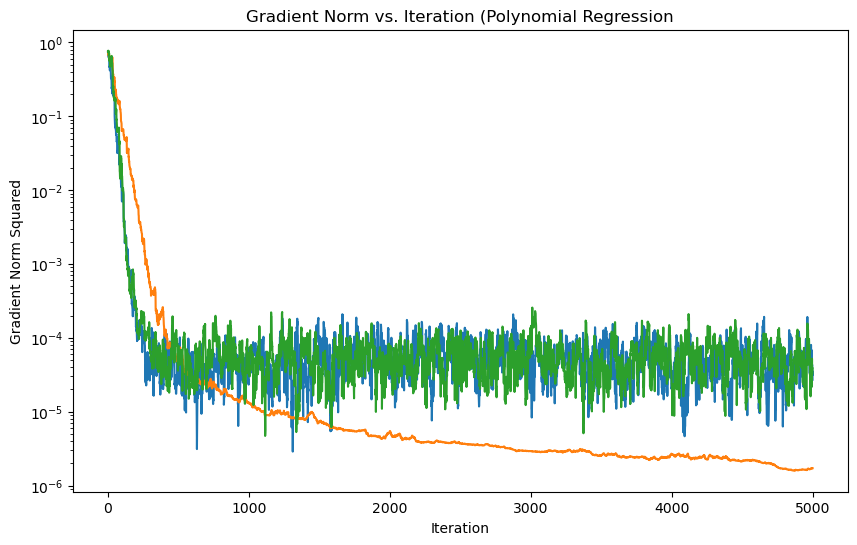

In [16]:
# Generate cosine data
X_raw, y, true_params = generate_cosine_data(m=100, d=3, noise=0.01)
degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X_raw)
scaler = StandardScaler()
X_poly = scaler.fit_transform(X_poly)

sgd = SGD(X_poly, y, num_iterations=5000, noise=0.01)
results = {}
for method in ["fixed", "halving", "diminishing"]:
    w, obj, grad, dist = sgd.optimize(stepsize_type=method)
    results[method] = {"w": w, "obj": obj, "grad": grad, "dist": dist}

# Plot
plt.figure(figsize=(10, 6))
for method in results:
    if len(results[method]["grad"]) > 0:
        plt.plot(results[method]["grad"], label=method.capitalize())
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm Squared")
plt.yscale("log")
plt.title("Gradient Norm vs. Iteration (Polynomial Regression")

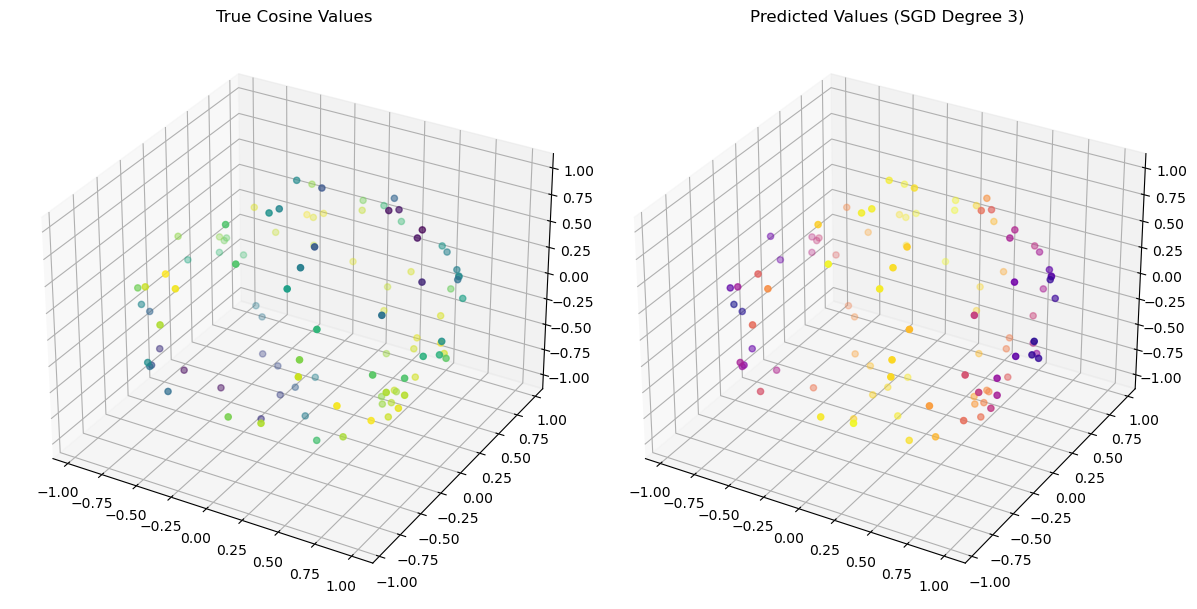

In [24]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(X_raw[:, 0], X_raw[:, 1], X_raw[:, 2], c=y, cmap='viridis')
ax1.set_title("True Cosine Values")

ax2.scatter(X_raw[:, 0], X_raw[:, 1], X_raw[:, 2], c=pred, cmap='plasma')
ax2.set_title("Predicted Values (SGD Degree 3)")
plt.tight_layout()
plt.show()

In [17]:
print("SGD Parameters for Spherical Run (degree = 3):")
print("="*60)
print(f"L (Lipschitz constant):        {sgd.L:.4f}")
print(f"c (strong convexity):          {sgd.c:.4f}")
print(f"M:                             {sgd.M:.4f}")
print(f"M_V:                           {sgd.M_V:.4f}")
print(f"M_G:                           {sgd.M_G:.4f}")
print(f"mu:                            {sgd.mu:.4f}")
print(f"mu_G:                          {sgd.mu_G:.4f}")
print(f"Fixed stepsize (alphā):        {sgd.fixed_alpha:.6f}")
print(f"Diminishing stepsize (beta):   {sgd.beta:.6f}")
print(f"Diminishing stepsize (gamma):  {sgd.gamma:.6f}")
print("="*60)

print("\nLearned Parameters from Each Stepsize Strategy:")
print("-" * 60)
for method in results:
    w_method = results[method]["w"]
    print(f"{method.capitalize()} stepsize:")
    print(f"  Bias term (w_0): {w_method[0]:.4f}")
    print(f"  Weights (w_1,...,w_n): {w_method[1:]}")

SGD Parameters for Spherical Run (degree = 3):
L (Lipschitz constant):        2.4097
c (strong convexity):          0.0000
M:                             0.0020
M_V:                           14.6897
M_G:                           15.6897
mu:                            1.0000
mu_G:                          1.0000
Fixed stepsize (alphā):        0.026450
Diminishing stepsize (beta):   1000000.026450
Diminishing stepsize (gamma):  37806828.999274

Learned Parameters from Each Stepsize Strategy:
------------------------------------------------------------
Fixed stepsize:
  Bias term (w_0): 0.8465
  Weights (w_1,...,w_n): [ 0.0010795  -0.00033402  0.00029986 -0.07792059 -0.05864911 -0.01845286
  0.03649274 -0.0052713   0.04244323  0.00075123  0.00100891 -0.00058197
  0.00217085 -0.00078094 -0.00010992 -0.00036606  0.0020749  -0.00114992
 -0.00019629]
Halving stepsize:
  Bias term (w_0): 0.8470
  Weights (w_1,...,w_n): [ 3.29599604e-05  2.41487945e-05  9.52340748e-05 -7.82938371e-02
 -5.830